In [1]:
import os, getpass
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
import sqlite3
# In memory
conn = sqlite3.connect(":memory:", check_same_thread = False)

In [3]:
!mkdir -p state_db && [ ! -f state_db/f1_race_data.db ] && echo "Placeholder for potential DB download if needed"

db_path = "../state_db/f1_race_data.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

Placeholder for potential DB download if needed


In [4]:
# Here is our checkpointer 
from langgraph.checkpoint.sqlite import SqliteSaver
memory = SqliteSaver(conn)

In [5]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langgraph.graph import END
from langgraph.graph import MessagesState

model = ChatOpenAI(model="gpt-4.1-nano",temperature=0)

class RaceSessionState(MessagesState):
    race_summary: str

def call_race_control(state: RaceSessionState):
    summary = state.get("race_summary", "")
    if summary:
        system_message = f"Summary of the race session so far: {summary}"
        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        messages = state["messages"]

    response = model.invoke(messages)
    return {"messages": response}

def generate_race_report(state: RaceSessionState):
    summary = state.get("race_summary", "")
    if summary:
        summary_message = (
            f"This is the race report so far: {summary}\n\n"
            "Update the report based on the new radio messages above:"
        )
    else:
        summary_message = "Generate a brief race report based on the radio messages above:"

    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"race_summary": response.content, "messages": delete_messages}

def should_generate_report(state: RaceSessionState):
    messages = state["messages"]
    if len(messages) > 6:
        return "generate_race_report"
    return END

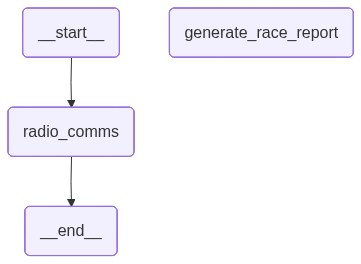

In [6]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START

workflow = StateGraph(RaceSessionState)
workflow.add_node("radio_comms", call_race_control)
workflow.add_node(generate_race_report)

workflow.add_edge(START, "radio_comms")
workflow.add_conditional_edges("radio_comms", should_generate_report)
workflow.add_edge("generate_race_report", END)

graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
config = {"configurable": {"thread_id": "monaco_gp_2025"}}

input_message = HumanMessage(content="Box this lap, box for hards.", name="RaceEngineer")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="Copy that, pitting now.", name="Driver_LEC")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="Traffic behind, VER +1.5s", name="RaceEngineer")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Understood. Box this lap to switch to hard tires.
================================== Ai Message ==================================

Copy that, pitting now.
================================== Ai Message ==================================

Acknowledged. Traffic behind, Verstappen is approximately 1.5 seconds behind.


In [8]:
config = {"configurable": {"thread_id": "monaco_gp_2025"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content='Box this lap, box for hards.', additional_kwargs={}, response_metadata={}, name='RaceEngineer', id='a9357b1d-ba8c-4549-bccb-a736efd1e6bd'), AIMessage(content='Understood. Box this lap to switch to hard tires.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 19, 'total_tokens': 31, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_950f36939b', 'id': 'chatcmpl-CTMPGXmIMVVshM85fCSbl1nIUT2rW', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--c1aee52b-a7df-44d6-aa6f-825ff4194166-0', usage_metadata={'input_tokens': 19, 'output_tokens': 12, 'total_tokens': 31, 'input_token_details': {'audio'

In [9]:
config = {"configurable": {"thread_id": "monaco_gp_2025"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content='Box this lap, box for hards.', additional_kwargs={}, response_metadata={}, name='RaceEngineer', id='a9357b1d-ba8c-4549-bccb-a736efd1e6bd'), AIMessage(content='Understood. Box this lap to switch to hard tires.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 19, 'total_tokens': 31, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_950f36939b', 'id': 'chatcmpl-CTMPGXmIMVVshM85fCSbl1nIUT2rW', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--c1aee52b-a7df-44d6-aa6f-825ff4194166-0', usage_metadata={'input_tokens': 19, 'output_tokens': 12, 'total_tokens': 31, 'input_token_details': {'audio'